# 🧪 1. Data Preprocessing & Setup

In this section, we will:
- Load and inspect the dataset
- Handle missing values
- Encode categorical variables
- Normalize or scale features if necessary

> 🔍 **Goal**: Clean and prepare the data for modeling by ensuring consistency and quality.

In [11]:
# 📦 Imports
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# 🧬 One-hot encoding function (safe)
def one_hot_encode(seq):
    mapping = {'a':[1,0,0,0], 't':[0,1,0,0], 'c':[0,0,1,0], 'g':[0,0,0,1]}
    return np.array([mapping.get(char, [0,0,0,0]) for char in seq.lower()])

# 📂 Load and clean data
df = pd.read_csv("final_dataset.csv")
df = df.dropna()
df = df[df['sequence'].apply(lambda x: isinstance(x, str))]

# ✅ Apply encoding
X = np.array([one_hot_encode(seq) for seq in df['sequence']])
y = df['label'].values

# 🔀 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📦 PyTorch Dataset
class DNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(DNADataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(DNADataset(X_test, y_test), batch_size=64)


# 🧠 Model 1: 1D CNN for Binary Classification of DNA Sequences into Promoter or Non-Promoter Regions


## 🔧 Model Definition


In [12]:
# 🔨 1D CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 15, 64)  # ✅ Fixed size
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, 4, 60]
        x = self.pool(torch.relu(self.conv1(x)))  # → [B, 32, 30]
        x = self.pool(torch.relu(self.conv2(x)))  # → [B, 64, 15]
        x = x.view(x.size(0), -1)  # → [B, 960]
        x = torch.relu(self.fc1(x))  # → [B, 64]
        return self.fc2(x)  # → [B, 2]


## 🚀 Training Function

In [16]:
def train_model(model, train_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # 🔍 Accuracy tracking
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"📘 Epoch {epoch+1}/{epochs} — Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return model



## 📊 Evaluation Function

In [14]:
# 📈 Evaluation + Confusion Matrix
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    print("\n🧾 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return all_preds, all_labels



## 🔥 Train and Evaluate CNN Model

📘 Epoch 1/10 — Loss: 0.5514, Accuracy: 71.75%
📘 Epoch 2/10 — Loss: 0.3846, Accuracy: 83.38%
📘 Epoch 3/10 — Loss: 0.3265, Accuracy: 85.80%
📘 Epoch 4/10 — Loss: 0.2620, Accuracy: 89.36%
📘 Epoch 5/10 — Loss: 0.2307, Accuracy: 90.76%
📘 Epoch 6/10 — Loss: 0.2023, Accuracy: 91.78%
📘 Epoch 7/10 — Loss: 0.1910, Accuracy: 92.46%
📘 Epoch 8/10 — Loss: 0.1623, Accuracy: 93.67%
📘 Epoch 9/10 — Loss: 0.1774, Accuracy: 93.09%
📘 Epoch 10/10 — Loss: 0.1476, Accuracy: 94.43%

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9311    0.8734    0.9013       774
           1     0.8808    0.9354    0.9073       774

    accuracy                         0.9044      1548
   macro avg     0.9060    0.9044    0.9043      1548
weighted avg     0.9060    0.9044    0.9043      1548



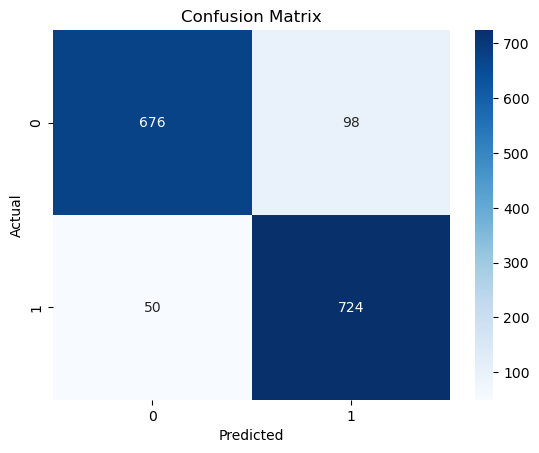

([1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,


In [17]:
# 1. Define model
model = CNNModel()

# 2. Train model
model = train_model(model, train_loader, epochs=10)

# 3. Save the trained model
torch.save(model.state_dict(), "cnn_promoter_model.pth")

# 4. Evaluate
evaluate_model(model, test_loader)



# 🎯 Part 1: Grad-CAM for 1D CNN

## ✅ Step 1: Hook + Grad-CAM Logic

In [18]:
# 📌 Grad-CAM hook storage
gradients = None
activations = None

# Hook to capture gradients
def save_gradient(grad):
    global gradients
    gradients = grad

# Hook to capture activations
def forward_hook(module, input, output):
    global activations
    activations = output


## ✅ Step 2: Attach Hook to CNN Layer

In [19]:
# 🧠 Attach hooks to conv2 layer
_ = model.conv2.register_forward_hook(forward_hook)
_ = model.conv2.register_full_backward_hook(lambda module, grad_input, grad_output: save_gradient(grad_output[0]))


## ✅ Step 3: Grad-CAM Heatmap Generator

In [20]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def generate_grad_cam(sequence_tensor, label, model):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_tensor = sequence_tensor.unsqueeze(0).to(device)
    output = model(sequence_tensor)

    # Predicted class
    pred_class = output.argmax().item()

    # Calculate gradient
    one_hot = torch.zeros((1, output.size()[-1]), dtype=torch.float).to(device)
    one_hot[0][label] = 1
    output.backward(gradient=one_hot)

    # Get gradients and activations
    pooled_gradients = torch.mean(gradients, dim=[0, 2])
    activation = activations[0]

    for i in range(activation.shape[0]):
        activation[i, :] *= pooled_gradients[i]

    heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)

    return heatmap


## ✅ Step 4: Visualize the Heatmap

C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


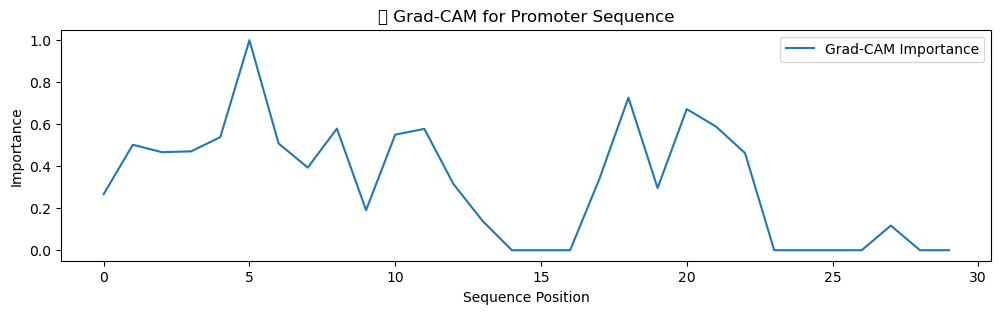

In [21]:
# 🔥 Visualize one example promoter sequence
index = np.where(y_test == 1)[0][0]
test_seq_tensor = torch.tensor(X_test[index], dtype=torch.float32)

heatmap = generate_grad_cam(test_seq_tensor, label=1, model=model)

plt.figure(figsize=(12, 3))
plt.plot(heatmap, label='Grad-CAM Importance')
plt.title("🔥 Grad-CAM for Promoter Sequence")
plt.xlabel("Sequence Position")
plt.ylabel("Importance")
plt.legend()
plt.show()


# 📈 Part 2: ROC Curve + AUC

C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


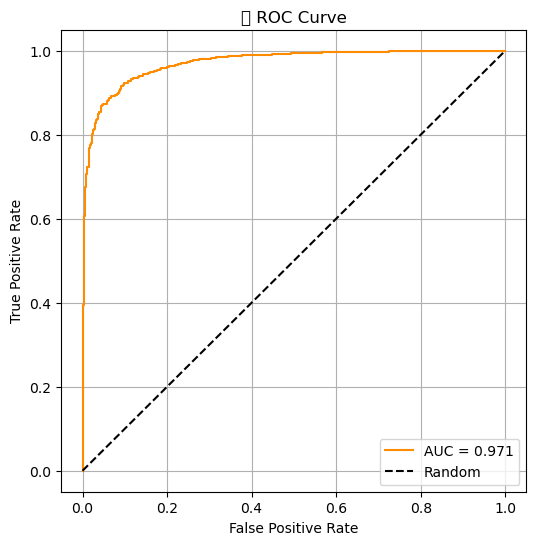

In [22]:
from sklearn.metrics import roc_curve, auc

def plot_roc(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    y_probs = []
    y_true = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_probs.extend(probs)
            y_true.extend(y_batch.numpy())

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title("📈 ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_roc(model, test_loader)
